In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#PARÁMETROS DEL BRAZO MK2 (en mm)
L1 = 135.0  # Longitud del primer eslabón
L2 = 147.0  # Longitud del segundo eslabón
a1 = 100.0  # Offset del efector final (Distancia del eje a P1)

In [ ]:
#FUNCIÓN 1: VECTOR DE ERROR (Cinemática Directa y Ecuaciones de Cierre)
def mk2_3D(q, target_pos):

    #Proyección radial en el plano XY
    R =

    #BLOQUE 1.1: RELLENAR CINEMÁTICA DIRECTA (P_inicial)

    X_actual =
    Y_actual =
    Z_actual =

    #BLOQUE 1.2: DEFINICIÓN DEL VECTOR DE ERROR f(q) = P_inicial - P_objetivo

    f1 =
    f2 =
    f3 =

    return np.array([f1, f2, f3])

In [ ]:
#FUNCIÓN 2: JACOBIANO J(q)
def Jmk2_3D(q):

    #Proyección radial en el plano XY
    R =

    #BLOQUE 2: RELLENAR MATRIZ JACOBIANA (J)

    #Fila 1 (Derivadas de X_inicial)
    J11 = # Derivada de X respecto a q0
    J12 = # Derivada de X respecto a q1
    J13 = # Derivada de X respecto a q2

    #Fila 2 (Derivadas de Y_inicial)
    J21 = # Derivada de Y respecto a q0
    J22 = # Derivada de Y respecto a q1
    J23 = # Derivada de Y respecto a q2

    #Fila 3 (Derivadas de Z_inicial)
    J31 = # Derivada de Z respecto a q0
    J32 = # Derivada de Z respecto a q1
    J33 = # Derivada de Z respecto a q2

    return np.array([[J11, J12, J13],
                     [J21, J22, J23],
                     [J31, J32, J33]])

In [ ]:
#FUNCIÓN 3: ALGORITMO DE NEWTON-RAPHSON (Iteración)
def NR_3D_inverse_kinematics(target_pos, init_guess, max_iterations=50, tolerance=1e-6):

    q = init_guess.copy()
    for i in range(max_iterations):

        g = mk2_3D(q, target_pos)
        error_norm = np.linalg.norm(g)

        if error_norm < tolerance:
            print(f"Convergencia alcanzada en la iteración {i+1}. Error: {error_norm:.2e}")
            break

        J = Jmk2_3D(q)
        J_inv = np.linalg.inv(J)
        q = q - np.dot(J_inv, g)
    else:
        print(f"Máximo de iteraciones ({max_iterations}) alcanzado. Error final: {error_norm:.2e}")

    return q

In [ ]:
#BLOQUE DE PRUEBA
target_3D = np.array([250.0, 30.0, 90.0])

#Usamos una estimación inicial segura para evitar singularidades
init_guess_deg = np.array([10.0, 30.0, 40.0])
init_guess_rad = np.radians(init_guess_deg)

print(f"Objetivo: X={target_3D[0]:.1f}, Y={target_3D[1]:.1f}, Z={target_3D[2]:.1f}")

#Llamar a la función
q_final_rad = NR_3D_inverse_kinematics(target_3D, init_guess_rad)

#Convertir los ángulos finales de radianes a grados
q_final_deg = np.degrees(q_final_rad)

print("\n--- Resultado Final ---")
print(f"Ángulos q_final: q0={q_final_deg[0]:.2f}°, q1={q_final_deg[1]:.2f}°, q2={q_final_deg[2]:.2f}°")

Objetivo: X=250.0, Y=30.0, Z=90.0
Convergencia alcanzada en la iteración 7. Error: 4.06e-11

--- Resultado Final ---
Ángulos q_final: q0=6.84°, q1=-23.70°, q2=102.65°


In [ ]:
#Definir eslabones a partir de los ángulos obtenidos
def get_joint_coords(L1, L2, a1, q):

    #Conversión a radianes
    q0, q1, q2 = q[0], q[1], q[2]

    #Puntos Clave

    #P0: Origen
    P0 = np.array([0.0, 0.0, 0.0])

    #R_xy: Proyección radial en el plano XY
    R_xy = L1 * np.cos(q1)

    #Articulación 1
    P1 = np.array([
        R_xy * np.cos(q0),
        R_xy * np.sin(q0),
        L1 * np.sin(q1)
    ])

    #Articulación 2
    R_total = L1 * np.cos(q1) + L2 * np.cos(q1 + q2)

    P2 = np.array([
        R_total * np.cos(q0),
        R_total * np.sin(q0),
        L1 * np.sin(q1) + L2 * np.sin(q1 + q2)
    ])

    #Posición final
    R_efector = R_total + a1

    P_final = np.array([
        R_efector * np.cos(q0),
        R_efector * np.sin(q0),
        P2[2]
    ])

    return np.array([P0, P1, P2, P_final])

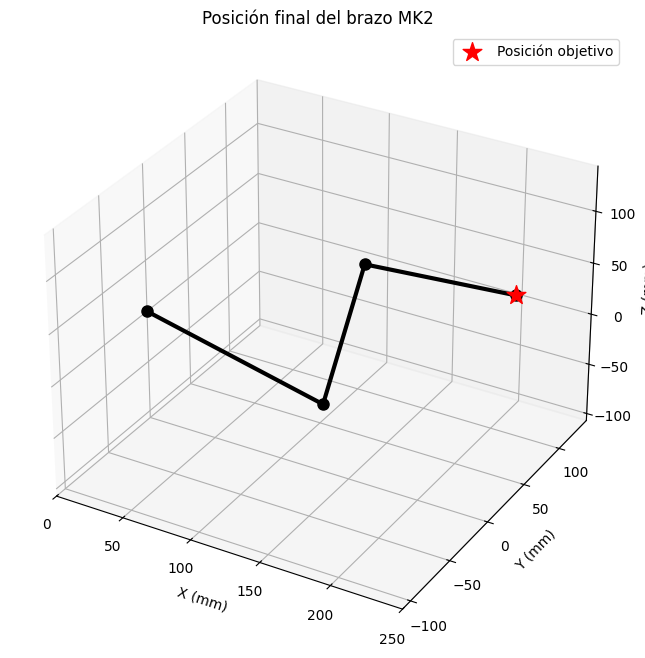

In [ ]:
#GRÁFICA DE LA POSICIÓN OBJETIVO
#Obtener las coordenadas de todas las articulaciones
puntos_brazo = get_joint_coords(L1, L2, a1, q_final_rad)

#Extrae coordenadas para la gráfica
X = puntos_brazo[:, 0]
Y = puntos_brazo[:, 1]
Z = puntos_brazo[:, 2]

#Crea la gráfica 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#Dibujar los eslabones
ax.plot(X, Y, Z, marker='o', linestyle='-', color='black', linewidth=3, markersize=8)

#Dibujar el punto deseado
target_pos = np.array([250.0, 30.0, 90.0]) # Usa el valor de tu target
ax.scatter(target_pos[0], target_pos[1], target_pos[2], color='red', s=200, label='Posición objetivo', marker='*')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title(f'Posición final del brazo MK2')

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.legend()
plt.show()